In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pymc as pm

from mpl_toolkits.mplot3d import Axes3D

In [95]:
#generate a bimodal distribution all of the below would be unknown
#and only the 'data' variable would be seen
N = 1000
loc_a = 90
std_a = 30
loc_b = 220
std_b = 90
ratio = .35
data1 = stats.norm.rvs(loc = loc_a, scale = std_a, size = int(N/2*ratio))
data2 = stats.norm.rvs(loc = loc_b, scale = std_b, size = int(N/2*(1-ratio)))
data = np.concatenate((data1, data2), axis = 0)

[  80.33629346   67.92579984  115.12866133   84.28615547   80.96807038
   99.17665434  106.31544986   79.76148475  114.73274767   96.21792791] ...


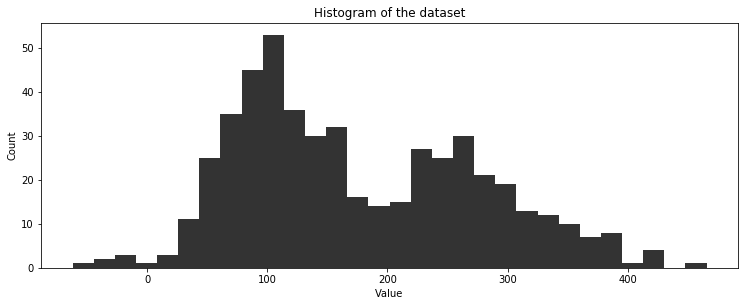

In [96]:
plt.hist(data, bins=30, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])
plt.xlabel('Value')
plt.ylabel('Count')
print data[:10], "..."

##### Data Generation Model
1. For each data point, choose cluster 0 with probability p, else choose cluster 1.

2. Draw a random variate from a Normal distribution with parameters μi and σi where i was chosen in step 1.

3. Repeat.

In [97]:
#model the assignment probability with uniform prior
p = pm.Uniform("p", 0., 1.)

assignment = pm.Categorical("assignment", [p, 1 - p],
                            size=data.shape[0])
print "prior assignment, with p = %.2f:" % p.value
print assignment.value[:10], "..."

prior assignment, with p = 0.26:
[1 1 1 0 0 0 0 1 1 1] ...


In [98]:
#model the two precisions with uniform priors
taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2

In [99]:
#model the centers of the clusters, which are mu parameters of the normal
#distributions used to model them. I will guess intentionally wrong with
mu1 = 50
std1 = std2 = 10.
mu2 = 250
centers = pm.Normal("centers",
                    mu = [mu1, mu2], 
                    tau = [1/std1**2, 1/std2**2],
                    size = 2
                   )

In [100]:
#map an assignment to one of the clusters

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]
@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print "Random assignments: ", assignment.value[:4], "..."
print "Assigned center: ", center_i.value[:4], "..."
print "Assigned precision: ", tau_i.value[:4], "..."

Random assignments:  [1 1 1 0] ...
Assigned center:  [ 233.34672883  233.34672883  233.34672883   52.71811905] ...
Assigned precision:  [ 0.00024085  0.00024085  0.00024085  0.00012787] ...


In [101]:
# We combine it with the observations.
observations = pm.Normal("obs", center_i, tau_i, value=data,
                         observed=True)

# Now we create a model class.
model = pm.Model([p, assignment, taus, centers])

In [102]:
mcmc = pm.MCMC(model)

In [103]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 16.8 sec

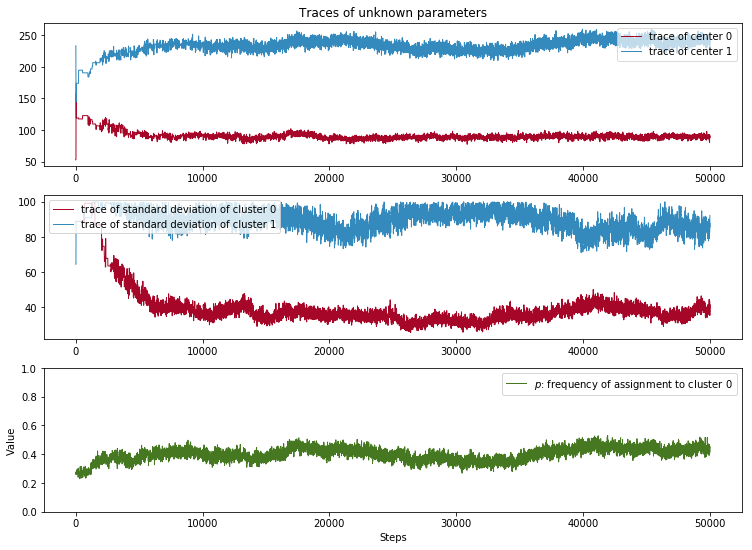

In [104]:
figsize(12.5, 9)
plt.subplot(311)
line_width = 1
center_trace = mcmc.trace("centers")[:]

# for pretty colors later in the book
colors = ["#348ABD", "#A60628"]
if center_trace[-1, 0] < center_trace[-1, 1]:
    colors = ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0",
         c=colors[0], lw=line_width)
plt.plot(center_trace[:, 1], label="trace of center 1",
         c=colors[1], lw=line_width)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]

plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0", c=colors[0], lw=line_width)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1", c=colors[1], lw=line_width)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0", color="#467821", lw=line_width)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.ylabel('Value')
plt.legend();

In [105]:
mcmc.sample(100000) #some extra sampling

 [-----------------100%-----------------] 100000 of 100000 complete in 32.7 sec

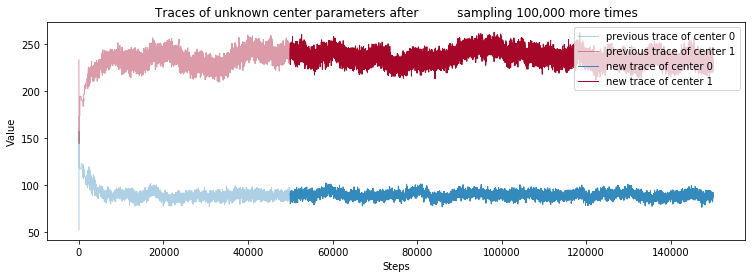

In [106]:
figsize(12.5, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
         lw=line_width, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
         lw=line_width, alpha=0.4, c=colors[0])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0",
         lw=line_width, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1",
         lw=line_width, c="#A60628")

plt.title("Traces of unknown center parameters after\
          sampling 100,000 more times")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.ylabel('Value')
plt.xlabel("Steps");

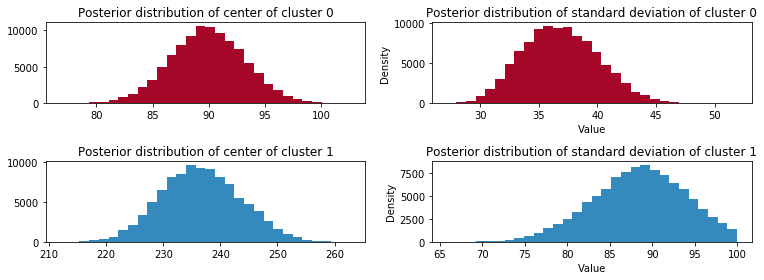

In [107]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior distribution of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior distribution of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    plt.ylabel('Density')
    plt.xlabel('Value')

plt.tight_layout();

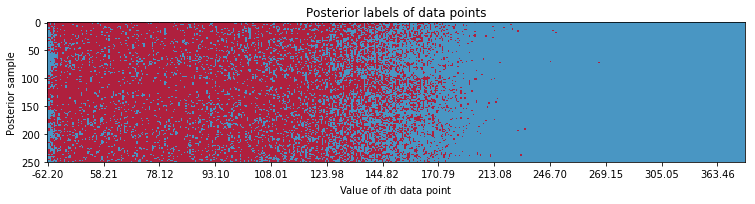

In [108]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("Posterior sample")
plt.xlabel("Value of $i$th data point")
plt.title("Posterior labels of data points");

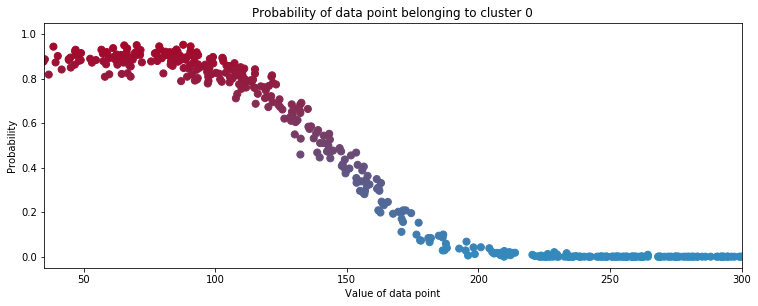

In [109]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH",
        colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)

plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("Probability")
plt.xlabel("Value of data point");

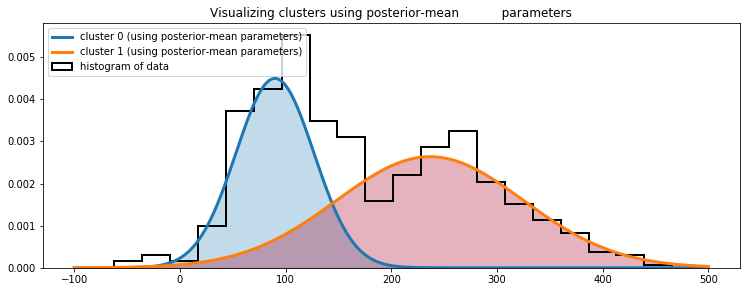

In [112]:
norm = stats.norm
x = np.linspace(-100, 500, 700)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
         lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x,
                        loc=posterior_center_means[1],
                        scale=posterior_std_means[1])
plt.plot(x, y, label="cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing clusters using posterior-mean\
           parameters");

##### Use for prediction

In [158]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace("p")[:]
x =  150

v = p_trace * norm_pdf(x, loc=center_trace[:, 0],
             scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1],
             scale=std_trace[:, 1])

print "Probability of belonging to cluster 0:", v.mean()

Probability of belonging to cluster 0: 0.20502


In [188]:
def prob_of_cluster_0(x):
    v = p_trace * norm_pdf(x, loc=center_trace[:, 0],
             scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1],
             scale=std_trace[:, 1])
    return v.mean()

In [189]:
prob_of_cluster_0(0)

0.87595000000000001

In [190]:
x = np.linspace(-100, 350, 100)
y = [prob_of_cluster_0(_) for _ in x]

Text(0.5,0,'Value of $i$th data point')

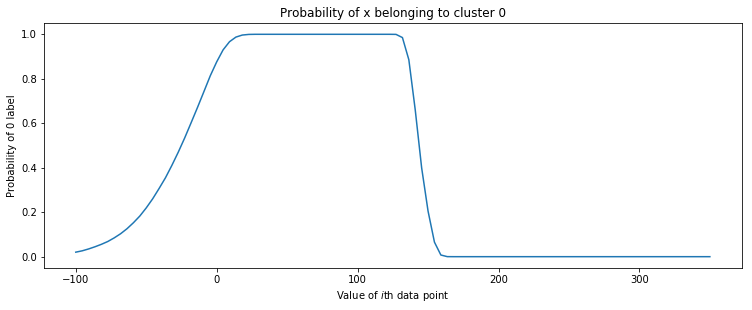

In [191]:

plt.plot(x,y)
plt.title("Probability of x belonging to cluster 0")
plt.ylabel("Probability of 0 label")
plt.xlabel("Value of $i$th data point")